In [1]:
import json
import math
import os
import random
from typing import Callable, Tuple
from IPython.display import display

import augly.image as imaugs
import pandas as pd
import timm
import torch
from PIL import Image
from torchvision import models, transforms
from torchvision.utils import save_image

In [2]:
base_dir = "/checkpoint/zoep/imagenet_analysis"
imagenet_val_data_table_path = (
    "/checkpoint/zoep/imagenet_analysis/imagenet_val_data_table.json"
)
dataset_dirs = {
    "imagenet_val": os.path.join(base_dir, "imagenet_val"),
    "imagenet_v2": os.path.join(
        base_dir, "imagenetv2-matched-frequency-format-val"
    )
}
aug_images_dirs = {
    "imagenet_val": os.path.join(base_dir, "imagenet_val_aug"),
    "imagenet_v2": os.path.join(base_dir, "imagenet_v2_aug"),
}
batch_size = 20

# send model + inputs to diff devices
devices = [
    torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
]

In [3]:
base_transforms = [
    lambda path: Image.open(path),
    lambda image: image.convert(mode="RGB"),
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

augmentations = {
    "blur": imaugs.Blur(radius=5),
    "random_noise": imaugs.RandomNoise(mean=0.1, var=0.2),
    "sharpen": imaugs.Sharpen(factor=10),
    "encoding_quality": imaugs.EncodingQuality(quality=15),
    "change_aspect_ratio": imaugs.ChangeAspectRatio(ratio=3.0),
    "opacity": imaugs.Opacity(level=0.5),
    "pixelization": imaugs.Pixelization(ratio=0.3),
    "scale": imaugs.Scale(factor=0.5),
    "color_jitter": imaugs.ColorJitter(
        brightness_factor=1.6,
        contrast_factor=1.6,
        saturation_factor=1.6,
    ),
    "hflip": imaugs.HFlip(),
    "perspective_transform": imaugs.PerspectiveTransform(),
    "rotate": imaugs.Rotate(degrees=50),
    "vflip": imaugs.VFlip(),
    "overlay_emoji": imaugs.OverlayEmoji(y_pos=0.3, emoji_size=0.8),
    "overlay_text": imaugs.OverlayText(font_size=0.5, x_pos=0.2, y_pos=0.1),
    "overlay_stripes": imaugs.OverlayStripes(
        line_angle=-30,
        line_density=0.9,
        line_width=0.4,
        line_type="dashed",
    ),
    "meme_format": imaugs.MemeFormat(),
}

In [4]:
def sample_images(test_set_dir, data_table_path=None):
    if data_table_path is not None:
        with open(data_table_path) as data_table_file:
            data_table = json.load(data_table_file)
            
        df = pd.DataFrame(data_table["data"])
        df.columns = ["filepath", "class", "class_name"]
        df["filepath"] = df["filepath"].apply(
            lambda path: os.path.basename(os.path.dirname(path))
        )
        df = df.drop_duplicates()
        class_dir_to_id = dict(
            zip(df["filepath"], [str(c) for c in df["class"]]),
        )
        
    sampled_test_images = []
    image_path_to_class_id = {}
    class_id_to_image_paths = {}
    for class_id in os.listdir(test_set_dir):
        class_dir = os.path.join(test_set_dir, class_id)
        if data_table_path is not None:
            class_id = class_dir_to_id[class_id]
        image_paths = os.listdir(class_dir)

        sampled_images = random.sample(image_paths, k=2)
        sampled_test_images.extend(
            [os.path.join(class_dir, image) for image in sampled_images]
        )
        image_path_to_class_id.update(
            {path : class_id for path in sampled_test_images[-2:]}
        )
        class_id_to_image_paths[int(class_id)] = sampled_test_images[-2:]
        
    sampled_test_images = random.sample(sampled_test_images, k=250)
    return sampled_test_images, image_path_to_class_id, class_id_to_image_paths


def augment_images(images, dataset, num_images=None):
    print(f"About to augment {len(images)} images using {len(augmentations.keys())} augmentations")
    aug_images_dir = aug_images_dirs[dataset]
    if not os.path.exists(aug_images_dir):
        os.mkdir(aug_images_dir)

    aug_images = {}
    for i, image in enumerate(images):
        if num_images is not None and i >= num_images:
            return aug_images
        
        if (i + 1) % 50 == 0:
            print(f"Augmented {i + 1}/{len(images)} images")
            
        aug_images_dict = {}
        for aug_name, aug in augmentations.items():
            aug_fp = os.path.join(
                aug_images_dir,
                f"{image.split('/')[-1].split('.')[0]}_{aug_name}.png",
            )
            aug_images_dict[aug_name] = aug_fp
            if os.path.exists(aug_fp):
                continue
                
            eval_transform = transforms.Compose(
                base_transforms[:1] + [aug] + base_transforms[1:]
            )
            save_image(eval_transform(image), aug_fp)
        aug_images[image] = aug_images_dict

    return aug_images

In [5]:
random.seed(1245)
sampled_images = {
    "imagenet_val": sample_images(
        dataset_dirs["imagenet_val"], imagenet_val_data_table_path
    ),
    "imagenet_v2": sample_images(dataset_dirs["imagenet_v2"], None),
}

# Augmentations

Original image


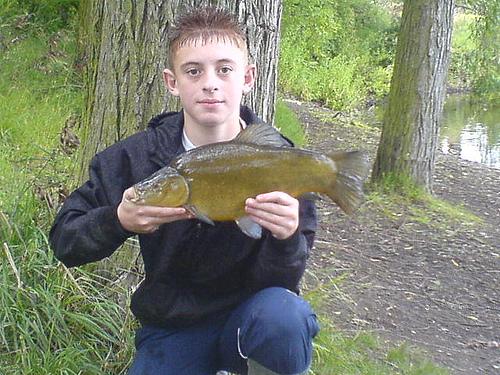

---------------
blur


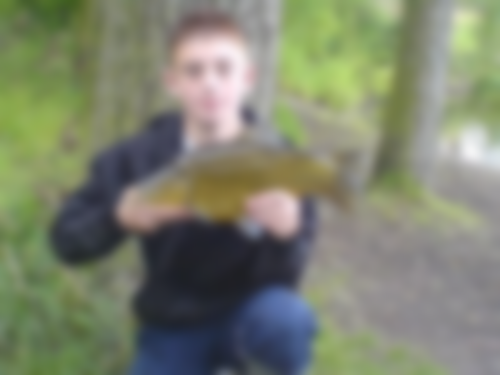

---------------
random_noise


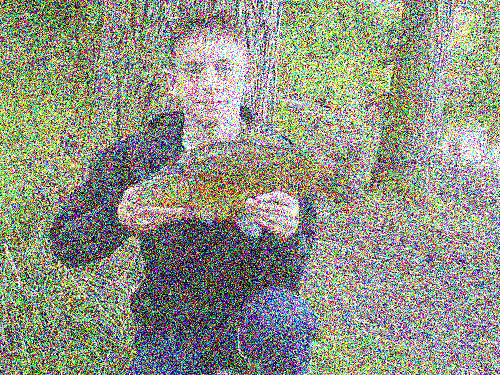

---------------
sharpen


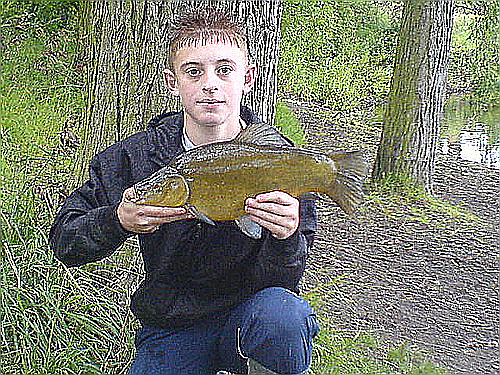

---------------
encoding_quality


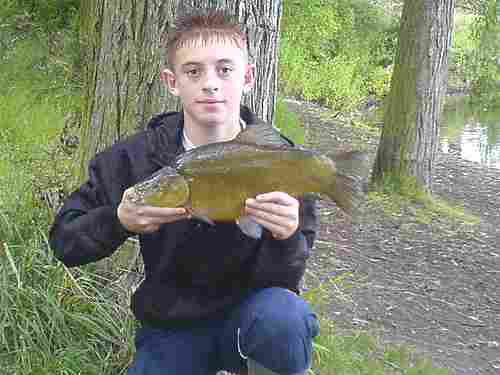

---------------
change_aspect_ratio


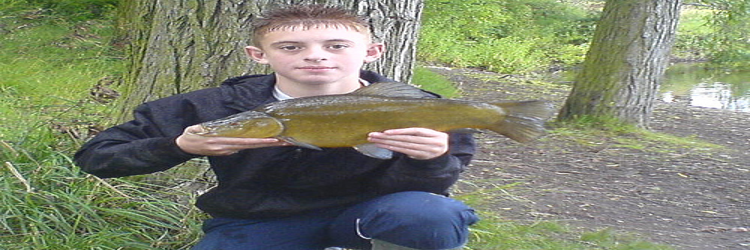

---------------
opacity


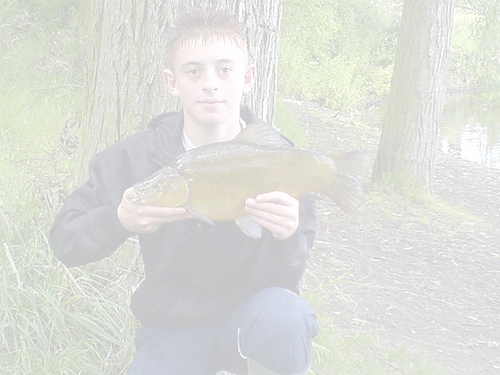

---------------
pixelization


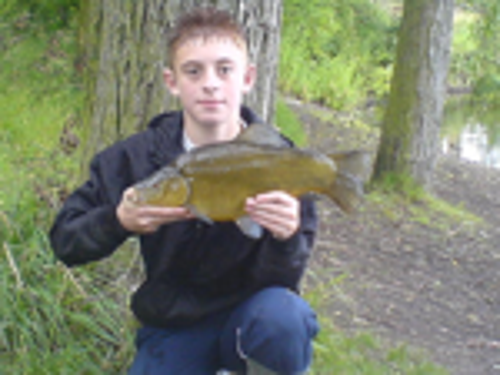

---------------
scale


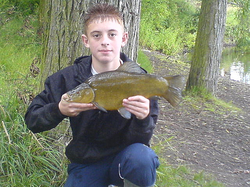

---------------
color_jitter


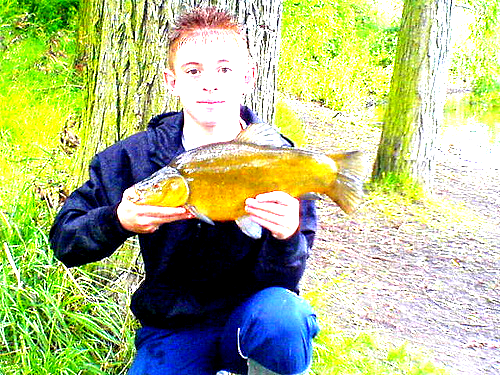

---------------
hflip


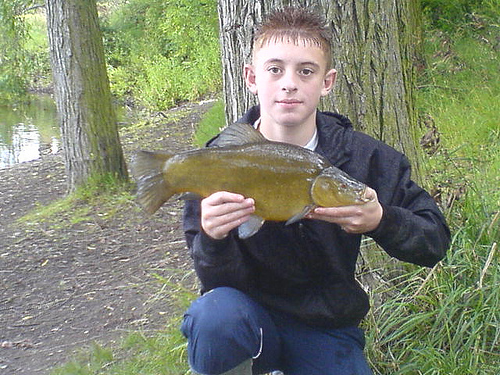

---------------
perspective_transform


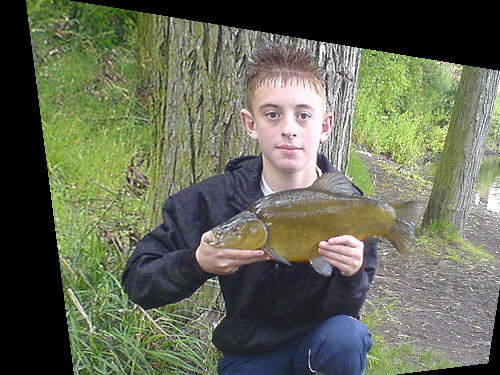

---------------
rotate


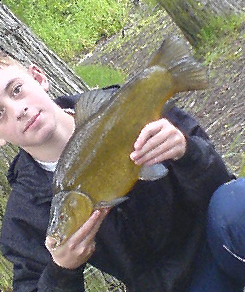

---------------
vflip


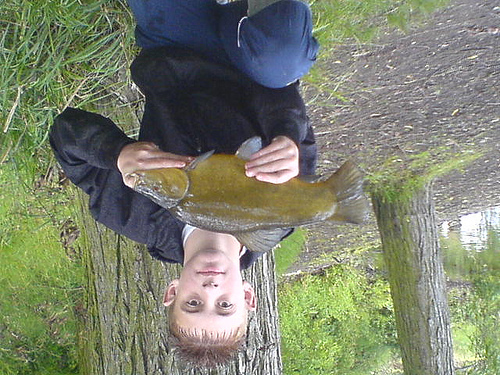

---------------
overlay_emoji


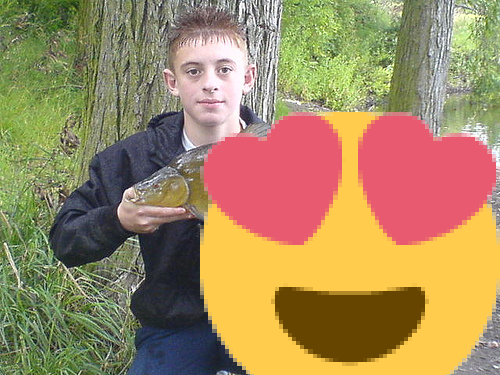

---------------
overlay_text


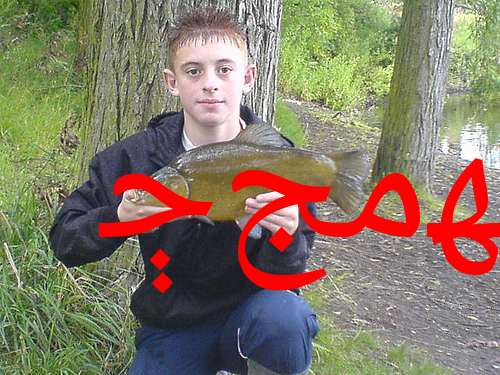

---------------
overlay_stripes


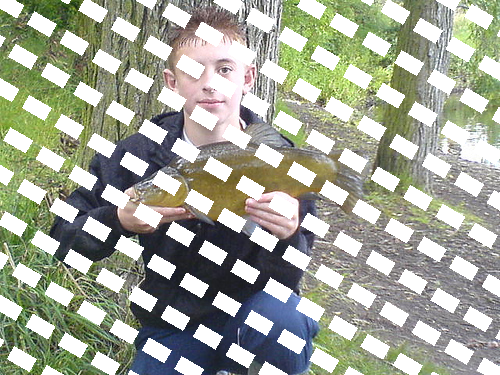

---------------
meme_format


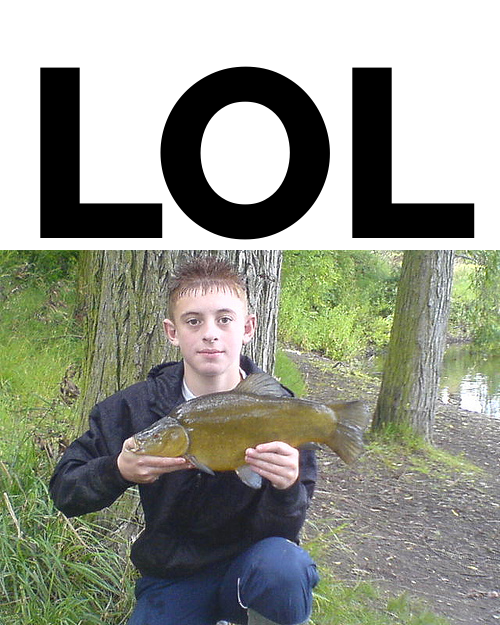

In [6]:
# We will now run all the following augmentations on the sampled images
img = Image.open(sampled_images["imagenet_val"][2][0][0])
print("Original image")
display(img)
for aug_name, aug in augmentations.items():
    print("---------------")
    print(aug_name)
    display(aug(img))

In [7]:
# Augment all the sampled images, write out to 
# {dataset : {image_path : {aug_name: aug_image}}}
aug_images = {
    "imagenet_val": augment_images(sampled_images["imagenet_val"][0], "imagenet_val", 250),
    "imagenet_v2": augment_images(sampled_images["imagenet_v2"][0], "imagenet_v2", 250),
}

About to augment 250 images using 17 augmentations
Augmented 50/250 images
Augmented 100/250 images
Augmented 150/250 images
Augmented 200/250 images
Augmented 250/250 images
About to augment 250 images using 17 augmentations
Augmented 50/250 images
Augmented 100/250 images
Augmented 150/250 images
Augmented 200/250 images
Augmented 250/250 images


In [8]:
def get_model(name):
    if name == "efficientnet":
        model = timm.create_model("tf_efficientnet_l2_ns", pretrained=False)
        model.load_state_dict(
            torch.load(
                os.path.join(base_dir, "tf_efficientnet_l2_ns-df73bb44.pth")
            )
        )
    elif name == "resnet":
        model = models.resnet152(pretrained=True)
    elif name == "vgg":
        model = models.vgg16(pretrained=True)
    else:
        print("Only 'efficientnet', 'resnet', or 'vgg' models are supported")

    model.eval()
    model = model.half()
    model.to(devices[1])
    return model


def evaluate_one_batch(
    sampled_images_batch,
    aug_sampled_images,
    aug_function,
    image_path_to_class_id,
    model,
):
    to_tensor = transforms.Compose(base_transforms)
    aug_sampled_tensors = [to_tensor(img) for img in aug_sampled_images]
    aug_sampled_tensors = torch.stack(aug_sampled_tensors, dim=0)
    aug_sampled_tensors = aug_sampled_tensors.half().to(devices[1])

    with torch.no_grad():
        model_results = model(aug_sampled_tensors)

    aug_sampled_tensors.to("cpu")
    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    results = []
    for i in range(len(top5_prob)):
        class_synset_id = os.path.basename(os.path.dirname(sampled_images_batch[i]))
        class_id = int(image_path_to_class_id[sampled_images_batch[i]])
        metadata = []
        aug_function(Image.open(sampled_images_batch[i]), metadata=metadata)

        results.append(
            {
                "ground_truth_id": class_id,
                "filepath": sampled_images_batch[i],
                "is_top1_pred": class_id == top5_catid[i][0].item(),
                "is_top5_pred": class_id in top5_catid[i],
                "intensity": metadata[-1]["intensity"],
            }
        )
    
    return results


def evaluate_model_on_augs(
    aug_name,
    aug_function: Callable,
    sampled_test_images,
    aug_sampled_images,
    image_path_to_class_id,
    model,
    batch,
    max_images_to_process=250,
) -> pd.DataFrame:
    num_batches = math.ceil(len(sampled_test_images) / batch)
    num_batches = (
        num_batches
        if max_images_to_process is None
        else min(num_batches, math.ceil(max_images_to_process / batch))
    )
    
    results = []
    for i in range(num_batches):
        sampled_test_img = sampled_test_images[i * batch : (i + 1) * batch]
        aug_img = sampled_test_img if aug_name is None else [
            aug_sampled_images[img][aug_name] for img in sampled_test_img
        ]
        results.extend(
            evaluate_one_batch(
                sampled_test_img,
                aug_img,
                aug_function,
                image_path_to_class_id,
                model,
            ),
        )

    return pd.DataFrame(results)


def compute_metrics(base: pd.DataFrame, aug: pd.DataFrame):
    metrics = []
    intensity = f"{aug['intensity'][0]:.2f}"
    for n in {1, 5}:
        base_n = base[f"is_top{n}_pred"]
        aug_n = aug[f"is_top{n}_pred"]

        xor_results = aug_n ^ base_n
        diffs = xor_results[xor_results == True]

        base_topn_accuracy = len(base_n[base_n == True]) / len(base_n)
        aug_topn_accuracy = len(aug_n[aug_n == True]) / len(aug_n)
        metrics.append(aug_topn_accuracy)
        metrics = [aug_topn_accuracy - base_topn_accuracy] + metrics
    
    metrics.append(intensity)
    return metrics


def return_top5_results(img: Image.Image, model) -> Tuple:
    transform = transforms.Compose(base_transforms[1:])
    tensor = transform(img).half().unsqueeze(0).to(devices[1])

    with torch.no_grad():
        model_results = model(tensor)

    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    return torch.topk(probabilities, 5)


def evaluate_model(model, dataset):
    test_set_dir = dataset_dirs[dataset]
    (
        sampled_test_images,
        image_path_to_class_id,
        class_id_to_image_paths,
    ) = sampled_images[dataset]
    num_sampled_images = len(sampled_test_images)
    aug_sampled_images = aug_images[dataset]

    random.seed(1)
    torch.cuda.empty_cache()
    
    baseline_df = evaluate_model_on_augs(
        None,
        imaugs.apply_lambda,
        sampled_test_images,
        aug_sampled_images,
        image_path_to_class_id,
        model,
        batch=20,
    )

    num_augs = len(augmentations.keys())
    metrics = []
    for i, (aug_name, aug) in enumerate(augmentations.items()):
        aug_df = evaluate_model_on_augs(
            aug_name,
            aug,
            sampled_test_images,
            aug_sampled_images,
            image_path_to_class_id,
            model,
            batch=batch_size,
        )
        print(f"Evaluated model on {i + 1}/{num_augs} augmentations")
        metrics.append(tuple([aug_name] + compute_metrics(baseline_df, aug_df)))
    
    metrics.sort(key = lambda tup: tup[1])
    metrics = [tuple(["NONE"] + compute_metrics(baseline_df, baseline_df))] + metrics

    metrics_df = pd.DataFrame(
        metrics,
        columns=[
            "Augmentation",
            "Top1 acc change",
            "Top5 acc change",
            "Top1 acc",
            "Top5 acc",
            "Intensity",
        ],
    )
    return metrics_df

# EfficientNet

In [9]:
model = "efficientnet"
model = get_model(model)

## Imagenet v2

In [10]:
# started at 9:38
dataset = "imagenet_v2"
efficient_v2_df = evaluate_model(model, dataset)
efficient_v2_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.812   
1                    blur           -0.468           -0.528     0.284   
2            random_noise           -0.208           -0.256     0.556   
3           overlay_emoji           -0.120           -0.160     0.652   
4                  rotate           -0.100           -0.132     0.680   
5     change_aspect_ratio           -0.084           -0.120     0.692   
6            pixelization           -0.080           -0.132     0.680   
7                   vflip           -0.076           -0.104     0.708   
8         overlay_stripes           -0.076           -0.092     0.720   
9                   scale           -0.052           -0.072     0.740   
10       encoding_quality           -0.036           -0.052     0.760   
11  perspective_transform           -0.032           -0.072     0.740   
12           overlay_text           -0.028           -0.064     0.748   
13            meme_format           -0.028           -0.060     0.752   
14                opacity           -0.024           -0.020     0.792   
15                sharpen           -0.016           -0.024     0.788   
16           color_jitter           -0.016           -0.028     0.784   
17                  hflip           -0.008           -0.028     0.784   

    Top5 acc Intensity  
0      0.952    100.00  
1      0.484      5.00  
2      0.744      0.02  
3      0.832     64.00  
4      0.852     27.78  
5      0.868     30.00  
6      0.872     70.00  
7      0.876    100.00  
8      0.876      7.85  
9      0.900     20.00  
10     0.916     85.00  
11     0.920     50.00  
12     0.924     25.00  
13     0.924     40.00  
14     0.928     50.00  
15     0.936    100.00  
16     0.936     16.00  
17     0.944    100.00

## Imagenet val

In [12]:
dataset = "imagenet_val"
efficient_val_df = evaluate_model(model, dataset)
efficient_val_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.904   
1                    blur           -0.324           -0.468     0.436   
2            random_noise           -0.160           -0.248     0.656   
3           overlay_emoji           -0.088           -0.136     0.768   
4     change_aspect_ratio           -0.080           -0.148     0.756   
5                  rotate           -0.076           -0.112     0.792   
6            pixelization           -0.064           -0.120     0.784   
7                   vflip           -0.048           -0.096     0.808   
8         overlay_stripes           -0.040           -0.072     0.832   
9        encoding_quality           -0.032           -0.068     0.836   
10                  scale           -0.032           -0.060     0.844   
11                opacity           -0.024           -0.048     0.856   
12           overlay_text           -0.024           -0.012     0.892   
13            meme_format           -0.024           -0.048     0.856   
14  perspective_transform           -0.020           -0.036     0.868   
15                  hflip           -0.008           -0.020     0.884   
16                sharpen           -0.004            0.008     0.912   
17           color_jitter           -0.004           -0.032     0.872   

    Top5 acc Intensity  
0      0.996    100.00  
1      0.672      5.00  
2      0.836      0.02  
3      0.908     64.00  
4      0.916     30.00  
5      0.920     27.78  
6      0.932     70.00  
7      0.948    100.00  
8      0.956      7.85  
9      0.964     85.00  
10     0.964     20.00  
11     0.972     50.00  
12     0.972     25.00  
13     0.972     40.00  
14     0.976     50.00  
15     0.988    100.00  
16     0.992    100.00  
17     0.992     16.00

# VGG

In [13]:
model = "vgg"
model = get_model(model)

## Imagenet v2

In [14]:
dataset = "imagenet_v2"
vgg_v2_df = evaluate_model(model, dataset)
vgg_v2_df

/private/home/zoep/anaconda3/envs/isc/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.468   
1            random_noise           -0.692           -0.468     0.000   
2                    blur           -0.668           -0.468     0.000   
3                  rotate           -0.656           -0.456     0.012   
4         overlay_stripes           -0.648           -0.452     0.016   
5            pixelization           -0.636           -0.456     0.012   
6           overlay_emoji           -0.632           -0.444     0.024   
7        encoding_quality           -0.620           -0.444     0.024   
8                 sharpen           -0.612           -0.444     0.024   
9     change_aspect_ratio           -0.608           -0.436     0.032   
10           color_jitter           -0.596           -0.424     0.044   
11           overlay_text           -0.576           -0.432     0.036   
12                  scale           -0.564           -0.440     0.028   
13                  vflip           -0.564           -0.420     0.048   
14  perspective_transform           -0.528           -0.384     0.084   
15            meme_format           -0.524           -0.392     0.076   
16                  hflip           -0.472           -0.372     0.096   
17                opacity           -0.420           -0.336     0.132   

    Top5 acc Intensity  
0      0.692    100.00  
1      0.000      0.02  
2      0.024      5.00  
3      0.036     27.78  
4      0.044      7.85  
5      0.056     70.00  
6      0.060     64.00  
7      0.072     85.00  
8      0.080    100.00  
9      0.084     30.00  
10     0.096     16.00  
11     0.116     25.00  
12     0.128     20.00  
13     0.128    100.00  
14     0.164     50.00  
15     0.168     40.00  
16     0.220    100.00  
17     0.272     50.00

## Imagenet val

In [15]:
dataset = "imagenet_val"
vgg_val_df = evaluate_model(model, dataset)
vgg_val_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.632   
1            random_noise           -0.840           -0.632     0.000   
2                    blur           -0.816           -0.624     0.008   
3         overlay_stripes           -0.808           -0.612     0.020   
4                  rotate           -0.784           -0.620     0.012   
5            pixelization           -0.772           -0.612     0.020   
6           overlay_emoji           -0.772           -0.608     0.024   
7     change_aspect_ratio           -0.760           -0.596     0.036   
8                 sharpen           -0.756           -0.604     0.028   
9        encoding_quality           -0.740           -0.588     0.044   
10           color_jitter           -0.740           -0.592     0.040   
11                  scale           -0.684           -0.568     0.064   
12           overlay_text           -0.672           -0.568     0.064   
13                  vflip           -0.656           -0.576     0.056   
14            meme_format           -0.632           -0.532     0.100   
15  perspective_transform           -0.592           -0.548     0.084   
16                  hflip           -0.548           -0.512     0.120   
17                opacity           -0.500           -0.468     0.164   

    Top5 acc Intensity  
0      0.840    100.00  
1      0.000      0.02  
2      0.024      5.00  
3      0.032      7.85  
4      0.056     27.78  
5      0.068     70.00  
6      0.068     64.00  
7      0.080     30.00  
8      0.084    100.00  
9      0.100     85.00  
10     0.100     16.00  
11     0.156     20.00  
12     0.168     25.00  
13     0.184    100.00  
14     0.208     40.00  
15     0.248     50.00  
16     0.292    100.00  
17     0.340     50.00

# Resnet

In [16]:
model = "resnet"
model = get_model(model)

## Imagenet v2

In [17]:
dataset = "imagenet_v2"
resnet_v2_df = evaluate_model(model, dataset)
resnet_v2_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.536   
1            random_noise           -0.744           -0.536     0.000   
2                    blur           -0.736           -0.536     0.000   
3         overlay_stripes           -0.712           -0.524     0.012   
4                  rotate           -0.708           -0.516     0.020   
5            pixelization           -0.664           -0.500     0.036   
6           overlay_emoji           -0.640           -0.488     0.048   
7        encoding_quality           -0.632           -0.480     0.056   
8     change_aspect_ratio           -0.632           -0.504     0.032   
9                 sharpen           -0.624           -0.468     0.068   
10           color_jitter           -0.608           -0.468     0.068   
11                  vflip           -0.588           -0.468     0.068   
12                  scale           -0.560           -0.452     0.084   
13            meme_format           -0.556           -0.448     0.088   
14           overlay_text           -0.540           -0.436     0.100   
15  perspective_transform           -0.524           -0.456     0.080   
16                  hflip           -0.468           -0.380     0.156   
17                opacity           -0.344           -0.292     0.244   

    Top5 acc Intensity  
0      0.756    100.00  
1      0.012      0.02  
2      0.020      5.00  
3      0.044      7.85  
4      0.048     27.78  
5      0.092     70.00  
6      0.116     64.00  
7      0.124     85.00  
8      0.124     30.00  
9      0.132    100.00  
10     0.148     16.00  
11     0.168    100.00  
12     0.196     20.00  
13     0.200     40.00  
14     0.216     25.00  
15     0.232     50.00  
16     0.288    100.00  
17     0.412     50.00

## Imagenet val

In [18]:
dataset = "imagenet_val"
resnet_val_df = evaluate_model(model, dataset)
resnet_val_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.672   
1            random_noise           -0.864           -0.672     0.000   
2                    blur           -0.860           -0.668     0.004   
3         overlay_stripes           -0.832           -0.652     0.020   
4                  rotate           -0.816           -0.656     0.016   
5            pixelization           -0.748           -0.628     0.044   
6                 sharpen           -0.744           -0.620     0.052   
7     change_aspect_ratio           -0.744           -0.636     0.036   
8        encoding_quality           -0.740           -0.620     0.052   
9            color_jitter           -0.732           -0.616     0.056   
10          overlay_emoji           -0.724           -0.584     0.088   
11                  vflip           -0.640           -0.556     0.116   
12            meme_format           -0.620           -0.572     0.100   
13           overlay_text           -0.600           -0.548     0.124   
14                  scale           -0.588           -0.540     0.132   
15  perspective_transform           -0.576           -0.516     0.156   
16                  hflip           -0.448           -0.412     0.260   
17                opacity           -0.340           -0.364     0.308   

    Top5 acc Intensity  
0      0.876    100.00  
1      0.012      0.02  
2      0.016      5.00  
3      0.044      7.85  
4      0.060     27.78  
5      0.128     70.00  
6      0.132    100.00  
7      0.132     30.00  
8      0.136     85.00  
9      0.144     16.00  
10     0.152     64.00  
11     0.236    100.00  
12     0.256     40.00  
13     0.276     25.00  
14     0.288     20.00  
15     0.300     50.00  
16     0.428    100.00  
17     0.536     50.00

# Plot metrics
- 1 plot for each architecture: compare top5 accuracy change on each dataset
- 1 plot for each dataset: compare top5 accuracy change on each architecture

In [19]:
import plotly.express as px

In [20]:
def plot_metrics_for_model(dfs, datasets, filepath):
    num_augs = len(dfs[0]["Augmentation"])
    df_data = []
    for df, dataset in zip(dfs, datasets):
        df_data.extend(
            [
                tup
                for tup in sorted(
                    zip(df["Augmentation"], df["Top5 acc change"], [dataset] * num_augs),
                    key = lambda tup: tup[1],
                )
                if tup[0] != "NONE"
            ],
        )
        
    df = pd.DataFrame(
        df_data,
        columns=["Augmentation", "Top5 accuracy change", "Dataset"],
    )
    fig = px.bar(
        df,
        x="Augmentation",
        y="Top5 accuracy change",
        color="Dataset",
        barmode="group",
        height=500,
    )
    fig.write_image(filepath)
    return Image.open(filepath)


def plot_metrics_for_dataset(dfs, models, filepath):
    num_augs = len(dfs[0]["Augmentation"])
    df_data = []
    for df, model in zip(dfs, models):
        df_data.extend(
            [
                tup
                for tup in sorted(
                    zip(df["Augmentation"], df["Top5 acc change"], [model] * num_augs),
                    key = lambda tup: tup[1],
                )
                if tup[0] != "NONE"
            ],
        )
        
    df = pd.DataFrame(
        df_data,
        columns=["Augmentation", "Top5 accuracy change", "Model"],
    )
    fig = px.bar(
        df,
        x="Augmentation",
        y="Top5 accuracy change",
        color="Model",
        barmode="group",
        height=500,
    )
    fig.write_image(filepath)
    return Image.open(filepath)

## Efficientnet: top5 accuracy ∆ on Imagenet v1 vs v2

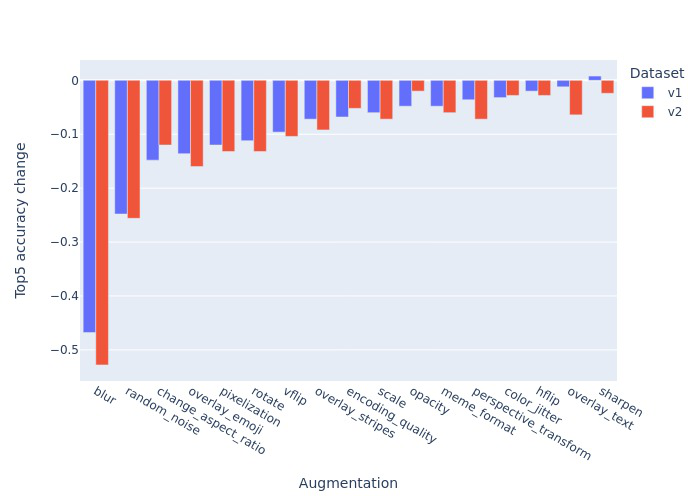

In [21]:
plot_metrics_for_model([efficient_val_df, efficient_v2_df], ["v1", "v2"], "/tmp/plot_eff.jpg")

## Resnet: top5 accuracy ∆ on Imagenet v1 vs v2

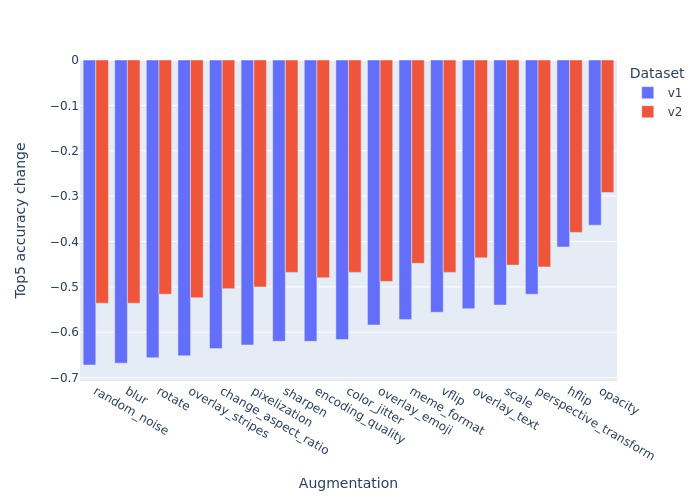

In [22]:
plot_metrics_for_model([resnet_val_df, resnet_v2_df], ["v1", "v2"], "/tmp/plot_res.jpg")

## VGG: top5 accuracy ∆ on Imagenet v1 vs v2

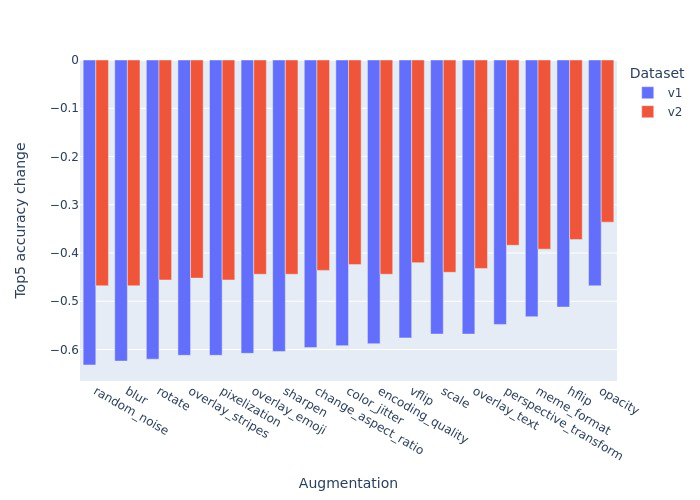

In [23]:
plot_metrics_for_model([vgg_val_df, vgg_v2_df], ["v1", "v2"], "/tmp/plot_vgg.jpg")

## Imagenet v1: top5 accuracy ∆ for VGG vs Resnet vs Efficientnet

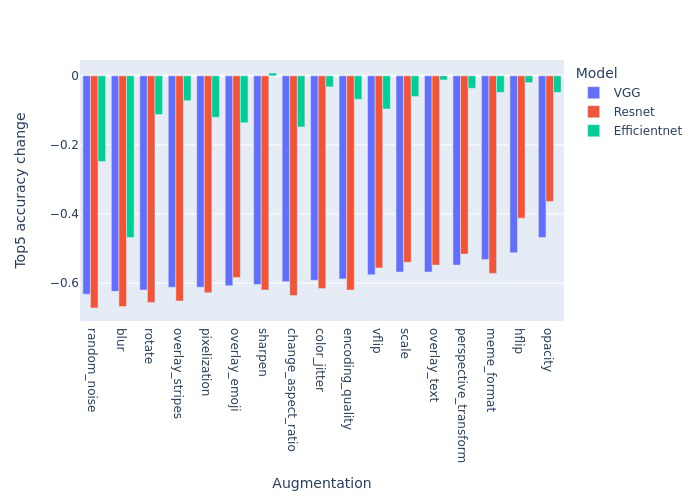

In [24]:
plot_metrics_for_dataset(
    [vgg_val_df, resnet_val_df, efficient_val_df],
    ["VGG", "Resnet", "Efficientnet"],
    "/tmp/plot_v1.jpg",
)

## Imagenet v2: top5 accuracy ∆ for VGG vs Resnet vs Efficientnet

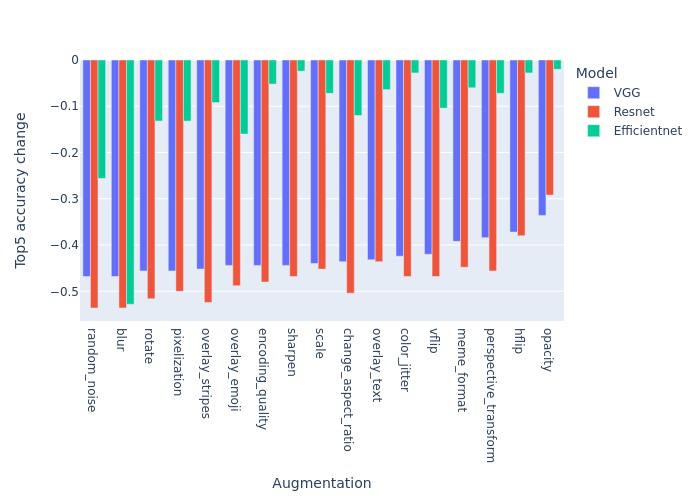

In [25]:
plot_metrics_for_dataset(
    [vgg_v2_df, resnet_v2_df, efficient_v2_df],
    ["VGG", "Resnet", "Efficientnet"],
    "/tmp/plot_v2.jpg"
)